In [1]:
import numpy as np
from tqdm import tqdm
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter.filedialog import askopenfilename
from temp_utils import *
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Input, Dense, Lambda

In [2]:
# input shape at least 32x32x3
img_size = 224 # default size

MobNetSmall = MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

for layer in MobNetSmall.layers[:]:
    layer.trainable = False

In [3]:
input = Input([None, None, 3], dtype=tf.uint8)
preprocess_layer = tf.cast(input, tf.float32)
preprocess_layer = tf.keras.applications.mobilenet.preprocess_input(preprocess_layer)

mobnet_extractor = Sequential([
    MobNetSmall,  # resulting embedding
    Flatten()
])

mobnet_extractor = mobnet_extractor(preprocess_layer)
mobnet_extractor = Model(inputs=preprocess_layer, outputs=mobnet_extractor)

mobnet_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 28224)             939120    
                                                                 
Total params: 939,120
Trainable params: 0
Non-trainable params: 939,120
_________________________________________________________________


In [4]:
filepath = r"C:\Temp\Nikko\vscode\plates\real"
filenames = os.listdir(filepath)
mobnet_extractor, MobNetSmall = load_pretrained()
weights_matrix = np.expand_dims(np.empty(mobnet_extractor.output_shape[1]), 1)
num_instances = len(filenames)

for img in tqdm(filenames, desc='Loading weight matrix'):
    img = cv2.cvtColor(cv2.imread(filepath+"/"+img), cv2.COLOR_BGR2RGB)
    imgarr = preprocess_img(img)
    imgarr = tf.cast(imgarr, tf.int32)
    embeddings = mobnet_extractor.predict(imgarr)[0]                                                # extracting embeddings
    embeddings = tf.nn.l2_normalize(embeddings)                                                     # normalize embeddings
    embeddings = np.expand_dims(embeddings, 1)
    weights_matrix = np.append(weights_matrix, embeddings, 1)                                       # creating the weights matrix with the embeddings

weights_matrix = np.delete(weights_matrix, 0, 1) # remove the empty column
weights_matrix = tf.constant_initializer(weights_matrix)

Loading weight matrix: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


In [5]:
class AggregationLayer(tf.keras.layers.Layer):
    def __init__(self, class_index):
        self.class_index = class_index
        super(AggregationLayer, self).__init__()
    
    def call(self, inputs, **kwargs):
        x = tf.nn.embedding_lookup(inputs[0], self.class_index)
        x = tf.reduce_max(x)
        return x

In [6]:
input = Input([img_size, img_size, 3], dtype=tf.uint8)
preprocess_layer = tf.cast(input, tf.float32)
preprocess_layer = tf.keras.applications.mobilenet.preprocess_input(preprocess_layer)

x = MobNetSmall(preprocess_layer)
x = Flatten()(x)

x = Lambda(lambda x: tf.nn.l2_normalize(x), name='l2_norm_layer')(x)
retrieval_output = Dense(
        num_instances,
        kernel_initializer=weights_matrix,
        activation="linear",
        trainable=False,
        name='retrieval_layer')(x)

labels = [fn.split('-')[0]+'-'+fn.split('-')[1] for fn in filenames]
class_id = set(labels)
selection_layer_output = list()
class_index_list = list()

for ci in class_id:
    class_index = [i for i, c in enumerate(labels) if c == ci]
    x = AggregationLayer(class_index)(retrieval_output)
    selection_layer_output.append(x)

concatenated_ouput = tf.stack(selection_layer_output, axis=0)

model = Model(inputs=preprocess_layer, outputs=concatenated_ouput)
model.summary()
model.compile()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 7, 7, 576)    939120      ['input_8[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 28224)        0           ['MobilenetV3small[2][0]']       
                                                                                                  
 l2_norm_layer (Lambda)         (None, 28224)        0           ['flatten_2[1][0]']        

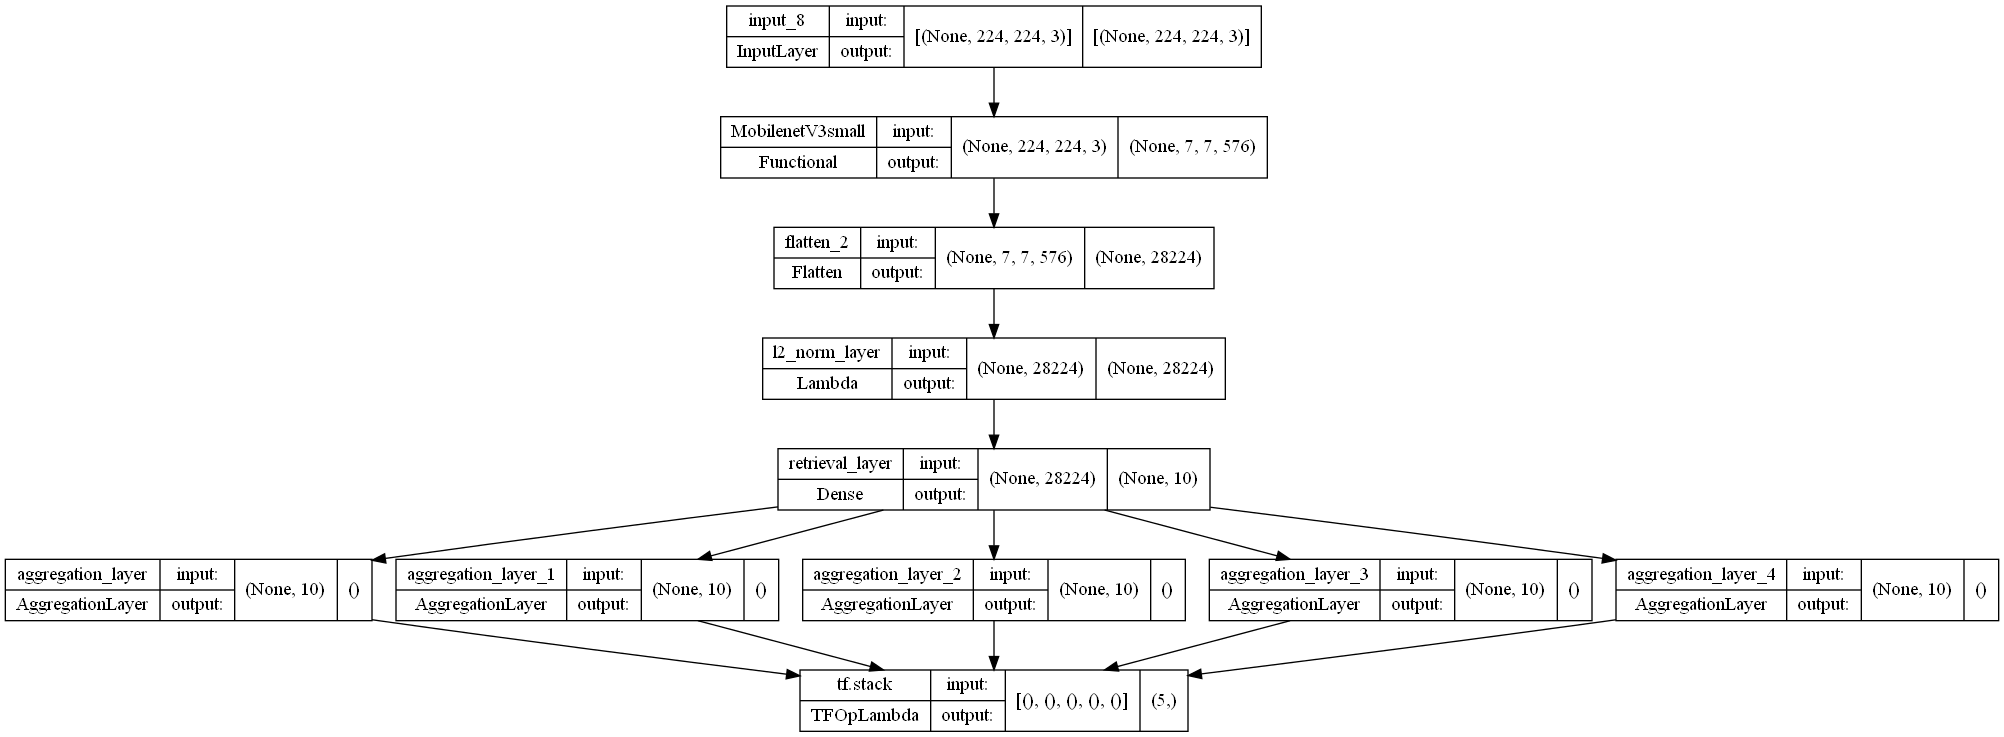

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

Test

In [8]:
filenames

['384-black-round-normal.png',
 '384-black-round-rotated180.png',
 '384-clear-square-normal.png',
 '384-clear-square-rotated180.png',
 '384-white-round-normal.png',
 '384-white-round-rotated180.png',
 '96-clear-round-normal.png',
 '96-clear-round-rotated180.png',
 '96-white-deep-normal.png',
 '96-white-deep-rotated180.png']

In [8]:
# add object to index
root = tk.Tk()
root.update()
filename = askopenfilename(filetypes=[("images", ["*.jpg", "*.jpeg", "*.png"])])
img = cv2.imread(filename)
root.destroy()

query_imgarr = preprocess_img(img)
model_output = model.predict(query_imgarr)
model_output

array([0.6946863 , 0.59326285, 0.62603784, 0.49454707, 0.92890763],
      dtype=float32)

In [9]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


Load and input test TFLite model

### Aggregation layer troubleshooting

In [18]:
def selection_layer(input):
    x, class_index = input
    x_ = tf.nn.embedding_lookup(x[0], class_index)
    return x_
     

In [19]:
agg_input = Input([10,], dtype=tf.float32)

labels = ['a', 'a', 'b', 'b', 'c', 'c', 'd', 'd', 'e', 'e']
class_id = set(labels)
selection_layer_output = list()
class_index_list = list()

for ci in class_id:
    class_index = [i for i, c in enumerate(labels) if c == ci]
    # x = Lambda(lambda x: tf.nn.embedding_lookup(x[0], class_index))(agg_input)
    x = Lambda(selection_layer)([agg_input, class_index])
    x = Lambda(lambda x: tf.reduce_max(x))(x)
    selection_layer_output.append(x)

aggregation_block = Model(inputs=agg_input, outputs=selection_layer_output)
aggregation_block.summary()
aggregation_block.compile()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 lambda_5 (Lambda)              (2,)                 0           ['input_13[0][0]']               
                                                                                                  
 lambda_7 (Lambda)              (2,)                 0           ['input_13[0][0]']               
                                                                                                  
 lambda_9 (Lambda)              (2,)                 0           ['input_13[0][0]']               
                                                                                            

In [20]:
tf.keras.utils.plot_model(aggregation_block)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_keras_history'

In [21]:
agg_input_test = tf.cast([0.4, 0.4, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.5, 0.5], tf.float32)
agg_input_test = tf.expand_dims(agg_input_test, axis=0)
aggregation_block.predict(agg_input_test)

[0.30000001192092896,
 0.5,
 0.20000000298023224,
 0.10000000149011612,
 0.4000000059604645]